#### This document is for analysis on FACT-E emotional well being (EWB).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import re

# Preliminary

In [3]:
# Read the CSV file - linked file 
file_path = "Merged_TSQIC_REDCap_ACCESS.xlsx" 
df = pd.read_excel(file_path)
df

,id,operation_date,redcap_event_name,dob,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,overall_distant_metastasis,...,ge1,ge2,ge3,ge4,ge5,ge6,readmission_30d,postop_comp,los,DischargeDate
0,1,NaT,surgery_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2012-04-27
1,1,NaT,surgery_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaT
2,1,NaT,surgery_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,1,2009-02-25,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2009-03-05
4,1,NaT,baseline_arm_1,1949-08-04,NaT,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10143,1766,NaT,baseline_arm_1,NaT,NaT,62.845917,NaN,1b,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
10144,1766,2025-02-26,surgery_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
10145,1767,NaT,baseline_arm_1,NaT,2025-03-03,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaT
10146,1767,NaT,baseline_arm_1,1971-12-18,NaT,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [4]:
# Extract columns with "GE1" to "GE6" with the first and second columns (patient id, duration)
# columns_to_extract = ["id", "redcap_event_name", "postop_comp", "los", "readmission_30d"] + [f"ge{i}" for i in range(1, 7)]
df_extracted = df.copy()#= df[columns_to_extract]

# Display the extracted data
print(df_extracted)

         id operation_date redcap_event_name        dob   qol_date  \
0         1            NaT     surgery_arm_1        NaT        NaT   
1         1            NaT     surgery_arm_1        NaT        NaT   
2         1            NaT     surgery_arm_1        NaT        NaT   
3         1     2009-02-25               NaN        NaT        NaT   
4         1            NaT    baseline_arm_1 1949-08-04        NaT   
...     ...            ...               ...        ...        ...   
10143  1766            NaT    baseline_arm_1        NaT        NaT   
10144  1766     2025-02-26     surgery_arm_1        NaT        NaT   
10145  1767            NaT    baseline_arm_1        NaT 2025-03-03   
10146  1767            NaT    baseline_arm_1 1971-12-18        NaT   
10147  1768            NaT    baseline_arm_1 1944-12-03        NaT   

       age_diagnosis  gender overall_primary_tumour overall_regional_ln  \
0                NaN     NaN                    NaN                 NaN   
1        

In [5]:
# Define GE score columns
ge_cols = ["ge1", "ge2", "ge3", "ge4", "ge5", "ge6"]

# Remove rows where all GE scores are NaN
df_filtered = df.dropna(subset=ge_cols, how="all")

# Group by 'id' and get unique redcap_event_name values per id
ids_with_both = df_filtered.groupby("id")["redcap_event_name"].unique()

# Filter for IDs that contain both 'baseline_arm_1' and 'preoperative_arm_1'
ids_with_both = ids_with_both[ids_with_both.apply(lambda x: {"baseline_arm_1", "preoperative_arm_1"}.issubset(set(x)))]

# Count the number of unique patients that satisfy the condition
num_ids_with_both = len(ids_with_both)

print(f"Number of IDs with both Baseline and Preoperative (after removing NaN GE scores): {num_ids_with_both}")

Number of IDs with both Baseline and Preoperative (after removing NaN GE scores): 283


In [6]:
# Count the number of rows for each patient (id)
patient_row_counts = df["id"].value_counts()

# Display the result
print(patient_row_counts)

id
209     66
629     52
276     49
263     48
169     48
        ..
155      1
1096     1
159      1
1753     1
1694     1
Name: count, Length: 1752, dtype: int64


In [7]:
# Get unique categories in "redcap_event_name"
unique_categories = df["redcap_event_name"].unique()

# Display the result
print(unique_categories)

['surgery_arm_1' nan 'baseline_arm_1' 'preoperative_arm_1']


In [8]:
# Create new columns for emotional well-being sub-domain scores
def process_ge_score(x, reverse=True):
    if isinstance(x, list):
        return [4 - val if reverse else val for val in x]
    return 4 - x if reverse else x

df["ge1_score"] = df["ge1"].apply(lambda x: process_ge_score(x, reverse=True))
df["ge2_score"] = df["ge2"].apply(lambda x: process_ge_score(x, reverse=False)) 
df["ge3_score"] = df["ge3"].apply(lambda x: process_ge_score(x, reverse=True))
df["ge4_score"] = df["ge4"].apply(lambda x: process_ge_score(x, reverse=True))
df["ge5_score"] = df["ge5"].apply(lambda x: process_ge_score(x, reverse=True))
df["ge6_score"] = df["ge6"].apply(lambda x: process_ge_score(x, reverse=True))

# Filter data for baseline_arm_1 and preoperative_arm_1
baseline_df = df[df["redcap_event_name"] == "baseline_arm_1"]
preoperative_df = df[df["redcap_event_name"] == "preoperative_arm_1"]

# distribution of FACT-E Emotional Well-Being sub-domain at 1) baseline and 2) pre-operative.

In [9]:
# Calculate distribution (value counts, ignoring missing values)
def count_values(series):
    value_counts = {}
    for value in series.dropna():
        if isinstance(value, list):
            # Count each value in the list
            for v in value:
                value_counts[v] = value_counts.get(v, 0) + 1
        else:
            # Count single values
            value_counts[value] = value_counts.get(value, 0) + 1
    return pd.Series(value_counts)

# Calculate distributions using the custom counting function
baseline_distribution = baseline_df[["ge1_score", "ge2_score", "ge3_score", 
                                "ge4_score", "ge5_score", "ge6_score"]].apply(count_values)
preoperative_distribution = preoperative_df[["ge1_score", "ge2_score", "ge3_score",
                                        "ge4_score", "ge5_score", "ge6_score"]].apply(count_values)

# Display results - Table
print("Baseline Distribution:")
print(baseline_distribution)

print("\nPreoperative Distribution:") 
print(preoperative_distribution)

Baseline Distribution:
     ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
0.0         62        104         37        137        105        188
1.0        118        135         44        154        104        180
2.0        242        320        106        237        169        259
3.0        296        299        172        267        257        244
4.0        334        161        622        243        400        169

Preoperative Distribution:
     ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
0.0          8         35         14         23         17         38
1.0         23         36         17         45         36         57
2.0         84        120         38         98         53         99
3.0        125        134         63        135        125        131
4.0        189        102        292        128        196        102


In [10]:
# Melt the data for visualization
baseline_melted = baseline_df.melt(id_vars=["id"], value_vars=["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"], var_name="Score Type", value_name="Score")
preoperative_melted = preoperative_df.melt(id_vars=["id"], value_vars=["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"], var_name="Score Type", value_name="Score")

In [11]:
baseline_melted["Timepoint"] = "Baseline"
preoperative_melted["Timepoint"] = "Preoperative"

combined_df = pd.concat([baseline_melted, preoperative_melted])
combined_df

,id,Score Type,Score,Timepoint
0,1,ge1_score,NaN,Baseline
1,1,ge1_score,NaN,Baseline
2,2,ge1_score,NaN,Baseline
3,2,ge1_score,NaN,Baseline
4,2,ge1_score,3.0,Baseline
...,...,...,...,...
12091,1752,ge6_score,3.0,Preoperative
12092,1752,ge6_score,NaN,Preoperative
12093,1762,ge6_score,NaN,Preoperative
12094,1764,ge6_score,NaN,Preoperative


In [12]:
# Ensure no duplicate issues
combined_df = combined_df.dropna()

combined_df

,id,Score Type,Score,Timepoint
4,2,ge1_score,3.0,Baseline
5,3,ge1_score,2.0,Baseline
8,4,ge1_score,4.0,Baseline
18,7,ge1_score,1.0,Baseline
20,8,ge1_score,4.0,Baseline
...,...,...,...,...
12077,1738,ge6_score,4.0,Preoperative
12080,1739,ge6_score,3.0,Preoperative
12081,1740,ge6_score,2.0,Preoperative
12086,1744,ge6_score,2.0,Preoperative


In [13]:
# Function to explode list values into separate rows
def process_score(score):
    if isinstance(score, list):
        return score
    return [score]

# Convert Score column to lists and explode
combined_df['Score'] = combined_df['Score'].apply(process_score)
combined_df = combined_df.explode('Score')

# Display example rows
combined_df

/tmp/ipykernel_1184410/65139597.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Score'] = combined_df['Score'].apply(process_score)


,id,Score Type,Score,Timepoint
4,2,ge1_score,3.0,Baseline
5,3,ge1_score,2.0,Baseline
8,4,ge1_score,4.0,Baseline
18,7,ge1_score,1.0,Baseline
20,8,ge1_score,4.0,Baseline
...,...,...,...,...
12077,1738,ge6_score,4.0,Preoperative
12080,1739,ge6_score,3.0,Preoperative
12081,1740,ge6_score,2.0,Preoperative
12086,1744,ge6_score,2.0,Preoperative


In [14]:
score_distribution_by_timepoint = combined_df.groupby(["Score", "Timepoint"]).size().unstack()
print(score_distribution_by_timepoint)

Timepoint  Baseline  Preoperative
Score                            
0.0             633           135
1.0             735           214
2.0            1333           492
3.0            1535           713
4.0            1929          1009


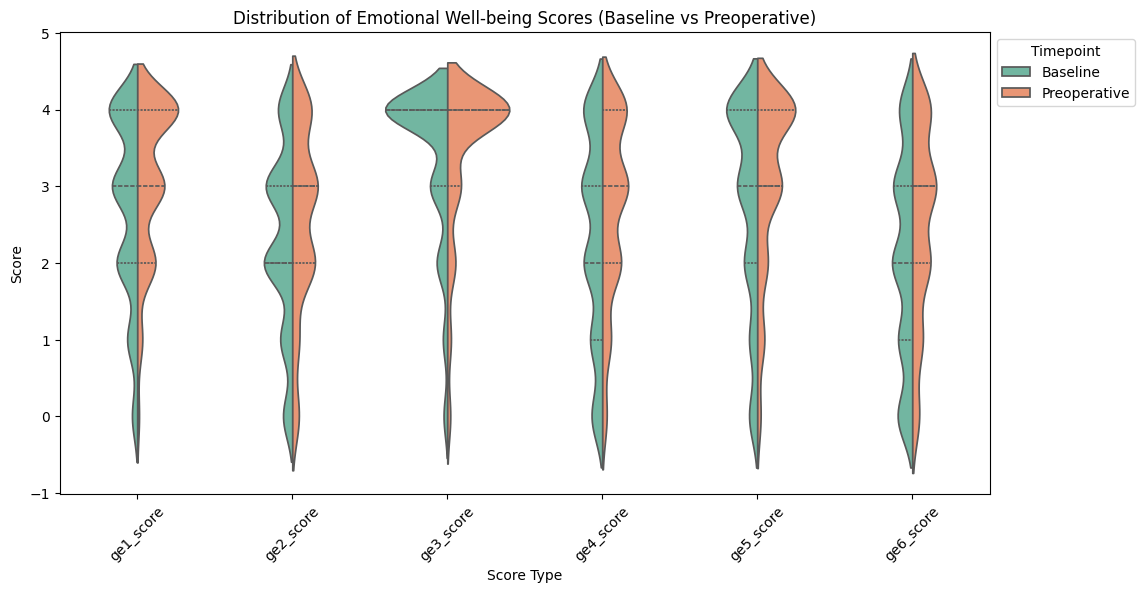

In [15]:
# === Violin Plot ===
plt.figure(figsize=(12, 6))
sns.violinplot(x="Score Type", y="Score", hue="Timepoint", data=combined_df, split=True, inner="quartile", palette="Set2")
plt.title("Distribution of Emotional Well-being Scores (Baseline vs Preoperative)")
plt.xticks(rotation=45)
plt.legend(title="Timepoint", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# frequency of those that have both baseline and pre-operative FACT-E

In [16]:
# Identify patients who have both baseline and preoperative
patients_with_both = combined_df.groupby("id")["Timepoint"].unique()
patients_with_both = patients_with_both[patients_with_both.apply(lambda x: {"Baseline", "Preoperative"}.issubset(set(x)))].index

# Keep only rows where id is in the list of patients_with_both
filtered_df = combined_df[combined_df["id"].isin(patients_with_both)]

print(filtered_df)

score_distribution_by_timepoint2 = filtered_df.groupby(["Score", "Timepoint"]).size().unstack()
print(score_distribution_by_timepoint2)

         id Score Type Score     Timepoint
137      55  ge1_score   2.0      Baseline
194      78  ge1_score   4.0      Baseline
282     125  ge1_score   3.0      Baseline
288     127  ge1_score   1.0      Baseline
290     128  ge1_score   4.0      Baseline
...     ...        ...   ...           ...
12066  1729  ge6_score   4.0  Preoperative
12073  1736  ge6_score   4.0  Preoperative
12075  1737  ge6_score   0.0  Preoperative
12080  1739  ge6_score   3.0  Preoperative
12086  1744  ge6_score   2.0  Preoperative

[3852 rows x 4 columns]
Timepoint  Baseline  Preoperative
Score                            
0.0             188            92
1.0             261           155
2.0             446           359
3.0             485           529
4.0             599           738


In [17]:
# Count the number of unique patients
num_patients_with_both = len(patients_with_both)

print(f"Number of patients with both Baseline and Preoperative: {num_patients_with_both}")

Number of patients with both Baseline and Preoperative: 283


In [18]:
ge_scores = ["ge1_score", "ge2_score", "ge3_score", "ge4_score", "ge5_score", "ge6_score"]

# Separate data by Timepoint
baseline_df_filtered = filtered_df[filtered_df["Timepoint"] == "Baseline"]
preoperative_df_filtered = filtered_df[filtered_df["Timepoint"] == "Preoperative"]

# Pivot table: Count occurrences of each Score for each Score Type
baseline_table = baseline_df_filtered.pivot_table(index="Score", columns="Score Type", aggfunc="size", fill_value=0)
preoperative_table = preoperative_df_filtered.pivot_table(index="Score", columns="Score Type", aggfunc="size", fill_value=0)

# Display the tables
print("Baseline Score Distribution Table:")
print(baseline_table)

print("\nPreoperative Score Distribution Table:")
print(preoperative_table)


Baseline Score Distribution Table:
Score Type  ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
Score                                                                       
0.0                16         36         10         35         32         59
1.0                37         45         17         61         34         67
2.0                85        116         31         75         58         81
3.0                97         74         54         91         92         77
4.0                99         59        207         70        115         49

Preoperative Score Distribution Table:
Score Type  ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  ge6_score
Score                                                                       
0.0                 6         27         10         15         11         23
1.0                15         27         13         32         24         44
2.0                60         88         29         68         41         73
3

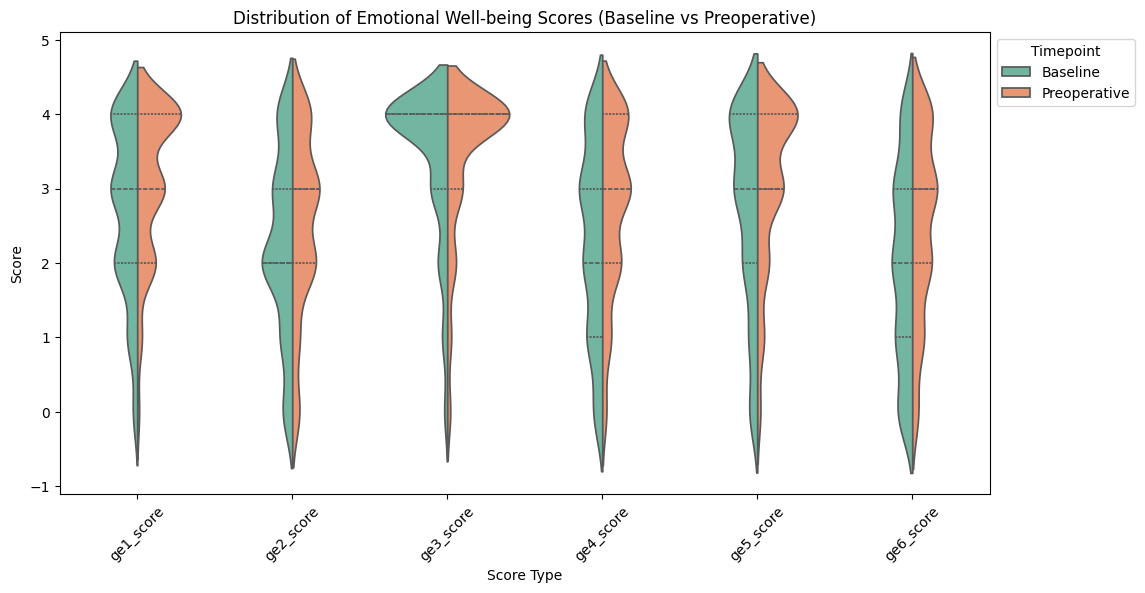

In [19]:
# === Violin Plot ===
plt.figure(figsize=(12, 6))
sns.violinplot(x="Score Type", y="Score", hue="Timepoint", data=filtered_df, split=True, inner="quartile", palette="Set2")
plt.title("Distribution of Emotional Well-being Scores (Baseline vs Preoperative)")
plt.xticks(rotation=45)
plt.legend(title="Timepoint", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

# calculate how many improve, stay the same, or decrease from baseline --> preop

In [20]:
filtered_df

,id,Score Type,Score,Timepoint
137,55,ge1_score,2.0,Baseline
194,78,ge1_score,4.0,Baseline
282,125,ge1_score,3.0,Baseline
288,127,ge1_score,1.0,Baseline
290,128,ge1_score,4.0,Baseline
...,...,...,...,...
12066,1729,ge6_score,4.0,Preoperative
12073,1736,ge6_score,4.0,Preoperative
12075,1737,ge6_score,0.0,Preoperative
12080,1739,ge6_score,3.0,Preoperative


In [21]:
# Average scores for duplicated (id, Score Type, Timepoint) entries
filtered_df_dup_avged = filtered_df.groupby(["id", "Score Type", "Timepoint"], as_index=False)["Score"].mean()
filtered_df_dup_avged

,id,Score Type,Timepoint,Score
0,55,ge1_score,Baseline,2.0
1,55,ge1_score,Preoperative,2.0
2,55,ge2_score,Baseline,2.0
3,55,ge2_score,Preoperative,2.0
4,55,ge3_score,Baseline,3.0
...,...,...,...,...
3361,1744,ge4_score,Preoperative,2.0
3362,1744,ge5_score,Baseline,4.0
3363,1744,ge5_score,Preoperative,4.0
3364,1744,ge6_score,Baseline,2.0


In [22]:
# Count expected number of rows per patient (should be 12 per patient)
expected_rows_per_patient = 12

# Count actual rows per patient
patient_counts = filtered_df_dup_avged.groupby("id").size()
patient_counts
# Identify patients who do NOT have exactly 12 rows
patients_missing_rows = patient_counts[patient_counts != expected_rows_per_patient]

# Display IDs and their actual row count
print("Patients with missing rows and their row count:")
print(patients_missing_rows)

Patients with missing rows and their row count:
id
260     11
548     10
566     11
788     11
826     11
898     11
1003    11
1012    11
1043    11
1106    11
1126     9
1313    11
1409    10
1551    11
1560    11
1629    11
1710     9
1715    11
1723     6
dtype: int64


In [23]:
# Pivot to make Score Types as columns and fill missing values with 0
pivot_df = filtered_df_dup_avged.pivot_table(index=["id", "Timepoint"], 
                                columns="Score Type", 
                                values="Score", 
                                fill_value=0)

# Sum across all Score Types for each (id, Timepoint)
pivot_df["Total Score"] = pivot_df.sum(axis=1)

# Reset index to bring back "id" and "Timepoint" as columns
pivot_df = pivot_df.reset_index()
print(pivot_df)



# Count the number of non-missing values for each row (before replacing NaNs with 0)
num_answered = filtered_df_dup_avged.pivot_table(index=["id", "Timepoint"], 
                                    columns="Score Type", 
                                    values="Score", 
                                    aggfunc=lambda x: x.notna().sum())
num_answered

/tmp/ipykernel_1184410/3399530565.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_df = filtered_df_dup_avged.pivot_table(index=["id", "Timepoint"],


Score Type    id     Timepoint  ge1_score  ge2_score  ge3_score  ge4_score  \
0             55      Baseline        2.0        2.0        3.0        1.0   
1             55  Preoperative        2.0        2.0        3.0        4.0   
2             78      Baseline        4.0        2.0        4.0        2.0   
3             78  Preoperative        4.0        2.0        4.0        3.0   
4            125      Baseline        3.0        3.0        4.0        4.0   
..           ...           ...        ...        ...        ...        ...   
561         1737  Preoperative        3.0        1.0        1.0        2.0   
562         1739      Baseline        1.0        2.0        4.0        2.0   
563         1739  Preoperative        4.0        3.0        4.0        3.0   
564         1744      Baseline        3.0        4.0        4.0        2.0   
565         1744  Preoperative        4.0        4.0        4.0        2.0   

Score Type  ge5_score  ge6_score  Total Score  
0              

Score Type         ge1_score  ge2_score  ge3_score  ge4_score  ge5_score  \
id   Timepoint                                                             
55   Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   
78   Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   
125  Baseline            1.0        1.0        1.0        1.0        1.0   
...                      ...        ...        ...        ...        ...   
1737 Preoperative        1.0        1.0        1.0        1.0        1.0   
1739 Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   
1744 Baseline            1.0        1.0        1.0        1.0        1.0   
     Preoperative        1.0        1.0        1.0        1.0        1.0   

Score Type         ge6_score  
id   Timepoint                
55   Baseline            1.0  
     Preoperative        1.0  
78   Baseline            1.0  
     Preoperative        1.0  
125  Baseline            1.0  
...                      ...  
1737 Preoperative        1.0  
1739 Baseline            1.0  
     Preoperative        1.0  
1744 Baseline            1.0  
     Preoperative        1.0  

[566 rows x 6 columns]

In [24]:
#show the table where it is missing
num_answered[num_answered.sum(axis=1) != 6]

,Score Type,ge1_score,ge2_score,ge3_score,ge4_score,ge5_score,ge6_score
id,Timepoint,,,,,,
260,Baseline,1.0,1.0,NaN,1.0,1.0,1.0
548,Baseline,1.0,1.0,NaN,1.0,NaN,1.0
566,Baseline,1.0,1.0,NaN,1.0,1.0,1.0
788,Preoperative,1.0,1.0,NaN,1.0,1.0,1.0
826,Preoperative,1.0,1.0,1.0,1.0,1.0,NaN
898,Baseline,1.0,1.0,NaN,1.0,1.0,1.0
1003,Baseline,1.0,1.0,1.0,NaN,1.0,1.0
1012,Baseline,1.0,1.0,1.0,NaN,1.0,1.0
1043,Baseline,1.0,1.0,NaN,1.0,1.0,1.0


In [25]:
# Ensure num_answered has the same index as pivot_df
num_answered_sum = num_answered.sum(axis=1).reindex(pivot_df.set_index(["id", "Timepoint"]).index)

# Compute the Adjusted Score safely
pivot_df["EWB subscale Score"] = (pivot_df["Total Score"] * 6) / num_answered_sum.values


# Display result
pivot_df

Score Type,id,Timepoint,ge1_score,ge2_score,ge3_score,ge4_score,ge5_score,ge6_score,Total Score,EWB subscale Score
0,55,Baseline,2.0,2.0,3.0,1.0,0.0,0.0,8.0,8.0
1,55,Preoperative,2.0,2.0,3.0,4.0,2.0,1.0,14.0,14.0
2,78,Baseline,4.0,2.0,4.0,2.0,4.0,1.0,17.0,17.0
3,78,Preoperative,4.0,2.0,4.0,3.0,4.0,3.0,20.0,20.0
4,125,Baseline,3.0,3.0,4.0,4.0,4.0,3.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...
561,1737,Preoperative,3.0,1.0,1.0,2.0,0.0,0.0,7.0,7.0
562,1739,Baseline,1.0,2.0,4.0,2.0,2.0,2.0,13.0,13.0
563,1739,Preoperative,4.0,3.0,4.0,3.0,3.0,3.0,20.0,20.0
564,1744,Baseline,3.0,4.0,4.0,2.0,4.0,2.0,19.0,19.0


In [26]:
# Pivot to get baseline and preoperative scores side by side
score_comparison = pivot_df.pivot(index="id", columns="Timepoint", values="EWB subscale Score")

# Compute the change: preoperative - baseline
score_comparison["Change"] = score_comparison["Preoperative"] - score_comparison["Baseline"]

# Categorize improvement, no change, or decline
score_comparison["Trend"] = score_comparison["Change"].apply(
    lambda x: "Improved" if x > 0 else "Same" if x == 0 else "Decreased"
)

# Display result
print(score_comparison[["Baseline", "Preoperative", "Change", "Trend"]])

Timepoint  Baseline  Preoperative  Change      Trend
id                                                  
55              8.0          14.0     6.0   Improved
78             17.0          20.0     3.0   Improved
125            21.0          16.0    -5.0  Decreased
127             5.0          12.0     7.0   Improved
128            22.0          23.0     1.0   Improved
...             ...           ...     ...        ...
1729           18.0          24.0     6.0   Improved
1736           20.0          21.0     1.0   Improved
1737           21.0           7.0   -14.0  Decreased
1739           13.0          20.0     7.0   Improved
1744           19.0          20.0     1.0   Improved

[283 rows x 4 columns]


/tmp/ipykernel_1184410/3399833115.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "gray", "red"])


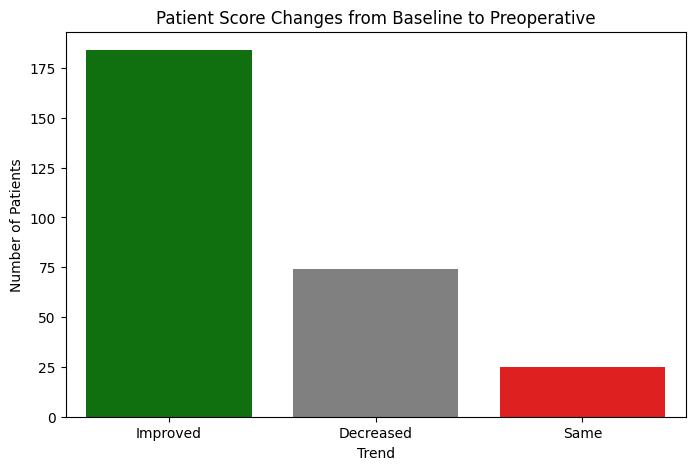

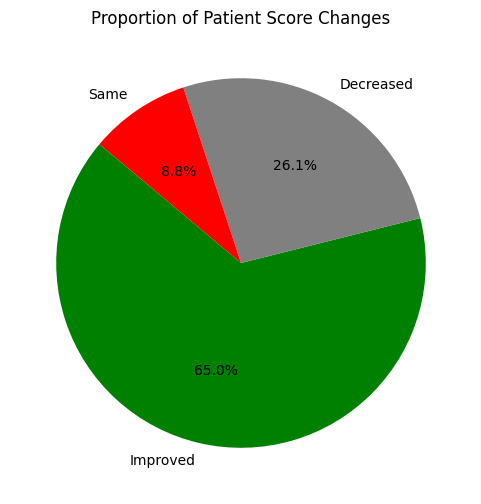

In [27]:
# Count the number of patients in each category
trend_counts = score_comparison["Trend"].value_counts()

# === 1. Bar Plot ===
plt.figure(figsize=(8, 5))
sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "gray", "red"])
plt.title("Patient Score Changes from Baseline to Preoperative")
plt.xlabel("Trend")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()

# === 2. Pie Chart ===
plt.figure(figsize=(6, 6))
plt.pie(trend_counts, labels=trend_counts.index, autopct="%1.1f%%", colors=["green", "gray", "red"], startangle=140)
plt.title("Proportion of Patient Score Changes")
plt.show()

# Categorize patients into: 1) improvers or 2) decliners / stay the same

In [28]:
score_comparison

Timepoint,Baseline,Preoperative,Change,Trend
id,,,,
55,8.0,14.0,6.0,Improved
78,17.0,20.0,3.0,Improved
125,21.0,16.0,-5.0,Decreased
127,5.0,12.0,7.0,Improved
128,22.0,23.0,1.0,Improved
...,...,...,...,...
1729,18.0,24.0,6.0,Improved
1736,20.0,21.0,1.0,Improved
1737,21.0,7.0,-14.0,Decreased


In [29]:
# Re-categorize into two groups
score_comparison["Trend Category"] = score_comparison["Change"].apply(lambda x: "Improved" if x > 0 else "Decreased/Same")

score_comparison

Timepoint,Baseline,Preoperative,Change,Trend,Trend Category
id,,,,,
55,8.0,14.0,6.0,Improved,Improved
78,17.0,20.0,3.0,Improved,Improved
125,21.0,16.0,-5.0,Decreased,Decreased/Same
127,5.0,12.0,7.0,Improved,Improved
128,22.0,23.0,1.0,Improved,Improved
...,...,...,...,...,...
1729,18.0,24.0,6.0,Improved,Improved
1736,20.0,21.0,1.0,Improved,Improved
1737,21.0,7.0,-14.0,Decreased,Decreased/Same


In [30]:
trend_counts = score_comparison["Trend Category"].value_counts()
trend_counts

Trend Category
Improved          184
Decreased/Same     99
Name: count, dtype: int64

/tmp/ipykernel_1184410/3720356275.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "red"])


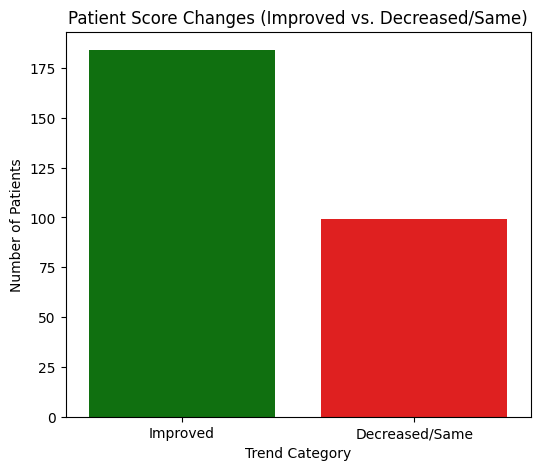

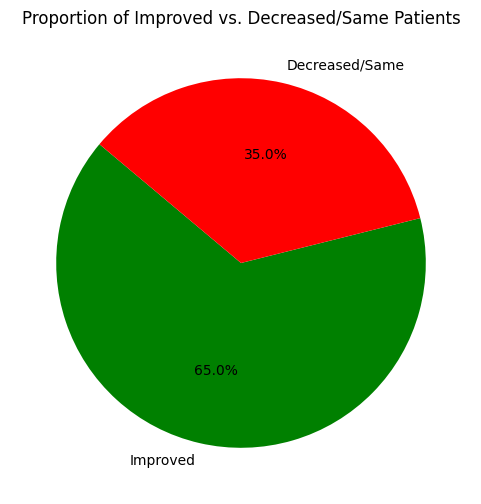

In [31]:
# === 1. Bar Plot ===
plt.figure(figsize=(6, 5))
sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=["green", "red"])
plt.title("Patient Score Changes (Improved vs. Decreased/Same)")
plt.xlabel("Trend Category")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.show()

# === 2. Pie Chart ===
plt.figure(figsize=(6, 6))
plt.pie(trend_counts, labels=trend_counts.index, autopct="%1.1f%%", colors=["green", "red"], startangle=140)
plt.title("Proportion of Improved vs. Decreased/Same Patients")
plt.show()

# statistically significantly associated with 1) occurrence of adverse events (postop_comp)

In [32]:
score_comparison

Timepoint,Baseline,Preoperative,Change,Trend,Trend Category
id,,,,,
55,8.0,14.0,6.0,Improved,Improved
78,17.0,20.0,3.0,Improved,Improved
125,21.0,16.0,-5.0,Decreased,Decreased/Same
127,5.0,12.0,7.0,Improved,Improved
128,22.0,23.0,1.0,Improved,Improved
...,...,...,...,...,...
1729,18.0,24.0,6.0,Improved,Improved
1736,20.0,21.0,1.0,Improved,Improved
1737,21.0,7.0,-14.0,Decreased,Decreased/Same


In [33]:
# Merge score_comparison with postop_comp data (assuming both have "id" as a common key)
merged_df = score_comparison.merge(df_extracted[["id", "postop_comp"]], on="id", how="left")
# Remove rows where postop_comp is missing
merged_df_removedNA = merged_df.dropna(subset=["postop_comp"])
merged_df_expanded = merged_df_removedNA.drop_duplicates()
merged_df_removedNA = merged_df_expanded.copy()
merged_df_removedNA

,id,Baseline,Preoperative,Change,Trend,Trend Category,postop_comp
4,55,8.0,14.0,6.0,Improved,Improved,0.0
8,78,17.0,20.0,3.0,Improved,Improved,1.0
16,78,17.0,20.0,3.0,Improved,Improved,0.0
20,125,21.0,16.0,-5.0,Decreased,Decreased/Same,0.0
25,127,5.0,12.0,7.0,Improved,Improved,1.0
...,...,...,...,...,...,...,...
2065,1622,17.0,16.0,-1.0,Decreased,Decreased/Same,1.0
2080,1643,17.0,19.0,2.0,Improved,Improved,1.0
2081,1653,18.0,18.0,0.0,Same,Decreased/Same,0.0
2095,1673,12.0,19.0,7.0,Improved,Improved,0.0


### Chi-square test

In [34]:
# Create a contingency table
contingency_table = pd.crosstab(merged_df_removedNA["Trend Category"], merged_df_removedNA["postop_comp"])
print(contingency_table)

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print("Chi-Square Statistic:", chi2)
print("p-value:", p)

postop_comp     0.0  1.0
Trend Category          
Decreased/Same   43   65
Improved         77   99
Chi-Square Statistic: 0.2788059712983493
p-value: 0.5974848953948424


### Fisher's exact test

In [35]:
odds_ratio, p_value = stats.fisher_exact(contingency_table)
print(f"Fisher's Exact Test p-value: {p_value}")

Fisher's Exact Test p-value: 0.5380723936875755


### Logistic test

In [36]:
# Convert categorical variable to binary (1 = Improved, 0 = Decreased/Same)
merged_df_removedNA["Trend Binary"] = (merged_df_removedNA["Trend Category"] == "Improved").astype(int)

# Logistic Regression Model
X = sm.add_constant(merged_df_removedNA["Trend Binary"])  # Predictor
y = merged_df_removedNA["postop_comp"]  # Outcome (0/1)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.680348
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            postop_comp   No. Observations:                  284
Model:                          Logit   Df Residuals:                      282
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                0.001101
Time:                        19:23:07   Log-Likelihood:                -193.22
converged:                       True   LL-Null:                       -193.43
Covariance Type:            nonrobust   LLR p-value:                    0.5141
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4132      0.197      2.102      0.036       0.028       0.798
Trend Binary    -0.1619

postop_comp          0.0       1.0
Trend Category                    
Decreased/Same  0.398148  0.601852
Improved        0.437500  0.562500


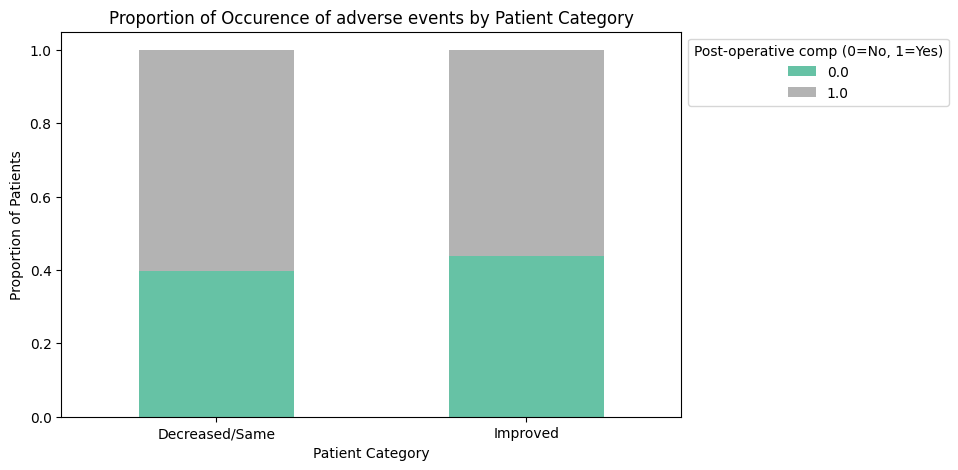

In [37]:
# Create proportion table
proportions = merged_df_removedNA.groupby("Trend Category")["postop_comp"].value_counts(normalize=True).unstack()
print(proportions)
# Plot bar chart
proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.xlabel("Patient Category")
plt.ylabel("Proportion of Patients")
plt.title("Proportion of Occurence of adverse events by Patient Category")
plt.legend(title="Post-operative comp (0=No, 1=Yes)",  bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()

# statistically significantly associated with 2) hospital length of stay (los)

In [38]:
# Merge score_comparison with los data
merged_df_los = score_comparison.merge(df_extracted[["id", "los"]], on="id", how="left")

# Remove rows where los is missing
merged_df_removedNA_los = merged_df_los.dropna(subset=["los"])
merged_df_expanded_los = merged_df_removedNA_los.drop_duplicates()
merged_df_removedNA_los = merged_df_expanded_los.copy()
merged_df_removedNA_los

,id,Baseline,Preoperative,Change,Trend,Trend Category,los
4,55,8.0,14.0,6.0,Improved,Improved,6.0
8,78,17.0,20.0,3.0,Improved,Improved,7.0
15,78,17.0,20.0,3.0,Improved,Improved,2.0
17,78,17.0,20.0,3.0,Improved,Improved,6.0
20,125,21.0,16.0,-5.0,Decreased,Decreased/Same,16.0
...,...,...,...,...,...,...,...
2065,1622,17.0,16.0,-1.0,Decreased,Decreased/Same,9.0
2080,1643,17.0,19.0,2.0,Improved,Improved,7.0
2081,1653,18.0,18.0,0.0,Same,Decreased/Same,6.0
2095,1673,12.0,19.0,7.0,Improved,Improved,6.0


In [39]:
# Count the number of occurrences for each Trend Category
trend_category_counts = merged_df_removedNA_los["Trend Category"].value_counts()

# Calculate the average Change for each Trend Category
avg_change_by_category = merged_df_removedNA_los.groupby("Trend Category")["Change"].mean()

# Print results
print("Count of each Trend Category:")
print(trend_category_counts)

print("\nAverage Change for each Trend Category:")
print(avg_change_by_category)


Count of each Trend Category:
Trend Category
Improved          192
Decreased/Same    110
Name: count, dtype: int64

Average Change for each Trend Category:
Trend Category
Decreased/Same   -2.717273
Improved          5.027083
Name: Change, dtype: float64


In [40]:
merged_df_removedNA_los.groupby("Trend Category")[["Change"]].describe()

Change                                                        
                count      mean       std        min    25%  50%    75%   max
Trend Category                                                               
Decreased/Same  110.0 -2.717273  2.789677 -13.166667 -4.375 -2.0 -0.625   0.0
Improved        192.0  5.027083  3.885266   0.500000  2.000  4.0  6.000  19.0

In [71]:
# Separate hospital length of stay (los) values by Trend Category
los_improved = merged_df_removedNA_los.loc[merged_df_removedNA_los["Trend Category"] == "Improved", "los"]
los_not_improved = merged_df_removedNA_los.loc[merged_df_removedNA_los["Trend Category"] == "Decreased/Same", "los"]

# Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(los_improved, los_not_improved, alternative="less")

print(f"Mann-Whitney U Test statistic: {u_stat}")
print(f"Mann-Whitney U Test p-value: {p_value}")

Mann-Whitney U Test statistic: 9260.5
Mann-Whitney U Test p-value: 0.036415482549796034


In [42]:
# Calculate mean LOS for each category
avg_los_improved = los_improved.mean()
avg_los_not_improved = los_not_improved.mean()

print(f"Average LOS for Improved: {avg_los_improved:.2f}")
print(f"Average LOS for Not Improved: {avg_los_not_improved:.2f}")

Average LOS for Improved: 11.39
Average LOS for Not Improved: 14.85


/tmp/ipykernel_1184410/2754884328.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2")


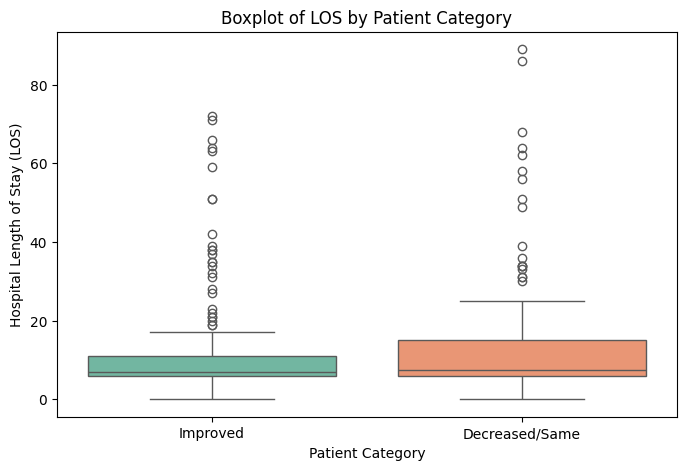

/tmp/ipykernel_1184410/2754884328.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2", inner="quartile")


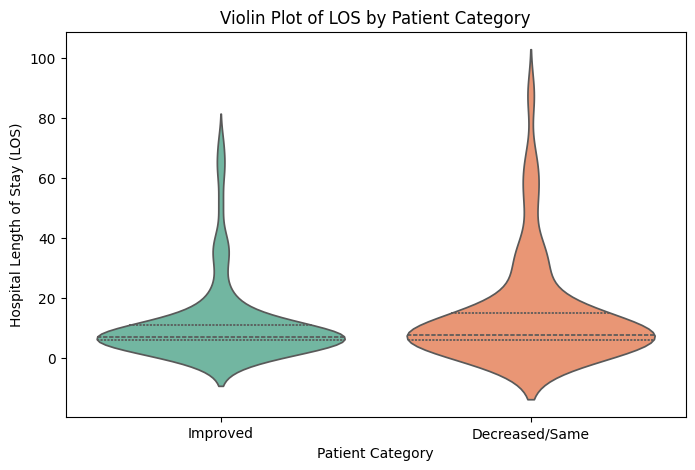

In [43]:
# Encode Trend Category as binary
merged_df_removedNA_los["Trend Category_binary"] = merged_df_removedNA_los["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

## ==== Boxplot ====
plt.figure(figsize=(8, 5))
sns.boxplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2")
plt.xlabel("Patient Category")
plt.ylabel("Hospital Length of Stay (LOS)")
plt.title("Boxplot of LOS by Patient Category")
plt.show()

## ==== Violin Plot ====
plt.figure(figsize=(8, 5))
sns.violinplot(x="Trend Category", y="los", data=merged_df_removedNA_los, palette="Set2", inner="quartile")
plt.xlabel("Patient Category")
plt.ylabel("Hospital Length of Stay (LOS)")
plt.title("Violin Plot of LOS by Patient Category")
plt.show()

# statistically significantly associated with 3) 30-day hospital readmission rate (readmission_30d)

In [44]:
# Merge score_comparison with readmission_30d data
merged_df_30re = score_comparison.merge(df_extracted[["id", "readmission_30d"]], on="id", how="left")

# Remove rows where readmission_30d is missing
merged_df_removedNA_30re = merged_df_30re.dropna(subset=["readmission_30d"])
merged_df_expanded_30re = merged_df_removedNA_30re.drop_duplicates()
merged_df_removedNA_30re = merged_df_expanded_30re.copy()
merged_df_removedNA_30re

,id,Baseline,Preoperative,Change,Trend,Trend Category,readmission_30d
4,55,8.0,14.0,6.0,Improved,Improved,0.0
8,78,17.0,20.0,3.0,Improved,Improved,0.0
20,125,21.0,16.0,-5.0,Decreased,Decreased/Same,0.0
25,127,5.0,12.0,7.0,Improved,Improved,0.0
36,128,22.0,23.0,1.0,Improved,Improved,1.0
...,...,...,...,...,...,...,...
2030,1577,14.0,6.0,-8.0,Decreased,Decreased/Same,0.0
2050,1597,12.0,17.0,5.0,Improved,Improved,0.0
2065,1622,17.0,16.0,-1.0,Decreased,Decreased/Same,0.0
2080,1643,17.0,19.0,2.0,Improved,Improved,0.0


### Chi-square test

In [45]:
# Create a contingency table
contingency_table_30re = pd.crosstab(merged_df_removedNA_30re["Trend Category"], merged_df_removedNA_30re["readmission_30d"])
print(contingency_table_30re)

# Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table_30re)

print(f"Chi-Square Test p-value: {p_value}")


readmission_30d  0.0  1.0
Trend Category           
Decreased/Same    70   15
Improved         119   22
Chi-Square Test p-value: 0.8283960765682783


### Fisher's exact test

In [46]:
odds_ratio, p_value = stats.fisher_exact(contingency_table_30re)
print(f"Fisher's Exact Test p-value: {p_value}")

Fisher's Exact Test p-value: 0.7129962085747794


### Logistic test

In [47]:
# Convert categorical variable to binary (1 = Improved, 0 = Decreased/Same)
merged_df_removedNA_30re["Trend Category_binary"] = merged_df_removedNA_30re["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

# Logistic Regression Model
X = sm.add_constant(merged_df_removedNA_30re["Trend Category_binary"])  # Predictor
y = merged_df_removedNA_30re["readmission_30d"]  # Outcome (0/1)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.445427
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        readmission_30d   No. Observations:                  226
Model:                          Logit   Df Residuals:                      224
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:               0.0007971
Time:                        19:23:11   Log-Likelihood:                -100.67
converged:                       True   LL-Null:                       -100.75
Covariance Type:            nonrobust   LLR p-value:                    0.6886
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5404      0.285     -5.414      0.000      -2.098      -0.

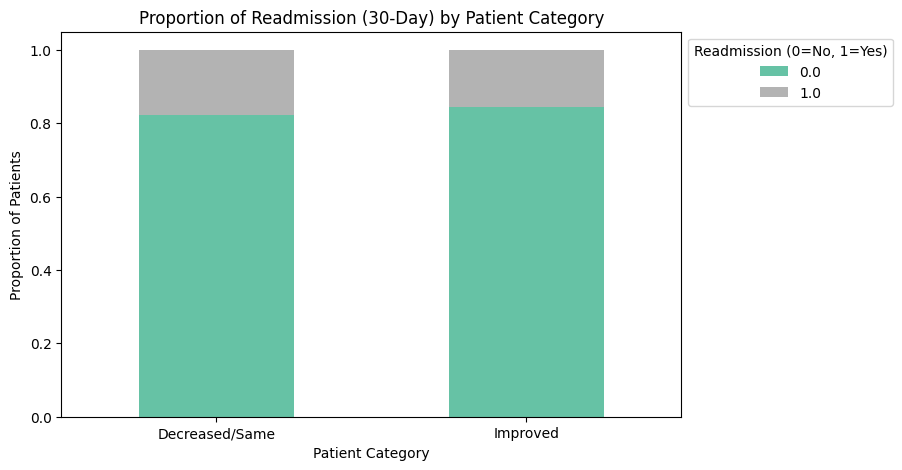

In [48]:
# Create proportion table
proportions = merged_df_removedNA_30re.groupby("Trend Category")["readmission_30d"].value_counts(normalize=True).unstack()

# Plot bar chart
proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.xlabel("Patient Category")
plt.ylabel("Proportion of Patients")
plt.title("Proportion of Readmission (30-Day) by Patient Category")
plt.legend(title="Readmission (0=No, 1=Yes)", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()


# statistically significantly associated with 4) age (age_diagnosis)

In [49]:
# Merge score_comparison with los data
merged_df_age = score_comparison.merge(df_extracted[["id", "age_diagnosis"]], on="id", how="left")

# Remove rows where los is missing
merged_df_removedNA_age = merged_df_age.dropna(subset=["age_diagnosis"])
merged_df_expanded_age = merged_df_removedNA_age.drop_duplicates()
merged_df_removedNA_age = merged_df_expanded_age.copy()
merged_df_removedNA_age

,id,Baseline,Preoperative,Change,Trend,Trend Category,age_diagnosis
2,55,8.0,14.0,6.0,Improved,Improved,64.617343
13,78,17.0,20.0,3.0,Improved,Improved,69.794725
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,64.110830
27,127,5.0,12.0,7.0,Improved,Improved,63.661700
32,128,22.0,23.0,1.0,Improved,Improved,62.698070
...,...,...,...,...,...,...,...
2170,1726,21.0,22.0,1.0,Improved,Improved,69.704260
2173,1729,18.0,24.0,6.0,Improved,Improved,72.565373
2180,1736,20.0,21.0,1.0,Improved,Improved,67.659158
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,76.946139


In [74]:
# Separate hospital age values by Trend Category
age_improved = merged_df_removedNA_age.loc[merged_df_removedNA_age["Trend Category"] == "Improved", "age_diagnosis"]
age_not_improved = merged_df_removedNA_age.loc[merged_df_removedNA_age["Trend Category"] == "Decreased/Same", "age_diagnosis"]

# Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(age_improved, age_not_improved, alternative="less")

print(f"Mann-Whitney U Test statistic: {u_stat}")
print(f"Mann-Whitney U Test p-value: {p_value}")

Mann-Whitney U Test statistic: 6271.0
Mann-Whitney U Test p-value: 0.06553689971156398


In [51]:
# Calculate mean age for each category
avg_age_improved = age_improved.mean()
avg_age_not_improved = age_not_improved.mean()

print(f"Average age for Improved: {avg_age_improved:.2f}")
print(f"Average age for Not Improved: {avg_age_not_improved:.2f}")

Average age for Improved: 64.40
Average age for Not Improved: 66.88


/tmp/ipykernel_1184410/2824880597.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trend Category", y="age_diagnosis", data=merged_df_removedNA_age, palette="Set2")


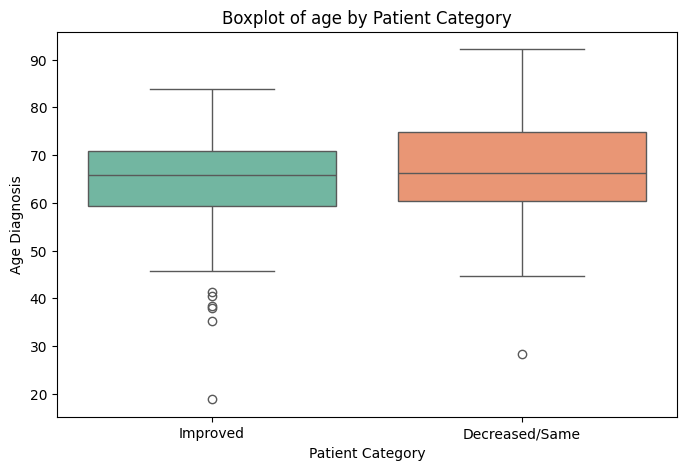

/tmp/ipykernel_1184410/2824880597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Trend Category", y="age_diagnosis", data=merged_df_removedNA_age, palette="Set2", inner="quartile")


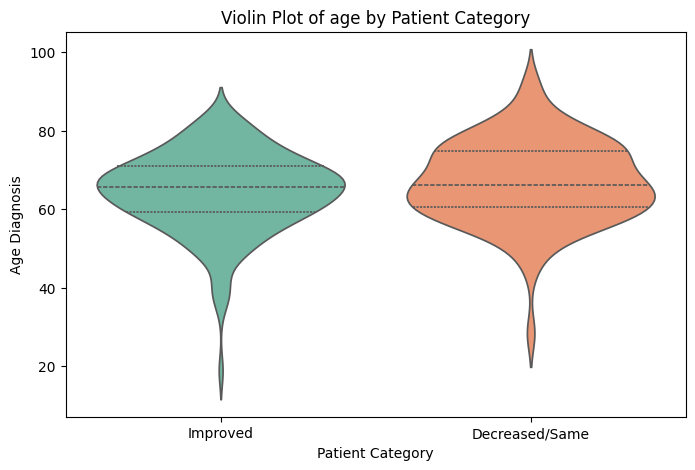

In [52]:
# Encode Trend Category as binary
merged_df_removedNA_age["Trend Category_binary"] = merged_df_removedNA_age["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

## ==== Boxplot ====
plt.figure(figsize=(8, 5))
sns.boxplot(x="Trend Category", y="age_diagnosis", data=merged_df_removedNA_age, palette="Set2")
plt.xlabel("Patient Category")
plt.ylabel("Age Diagnosis")
plt.title("Boxplot of age by Patient Category")
plt.show()

## ==== Violin Plot ====
plt.figure(figsize=(8, 5))
sns.violinplot(x="Trend Category", y="age_diagnosis", data=merged_df_removedNA_age, palette="Set2", inner="quartile")
plt.xlabel("Patient Category")
plt.ylabel("Age Diagnosis")
plt.title("Violin Plot of age by Patient Category")
plt.show()

# statistically significantly associated with 5) sex (gender)

In [53]:
# Merge score_comparison with gender data
merged_df_gender = score_comparison.merge(df_extracted[["id", "gender"]], on="id", how="left")

# Remove rows where gender is missing
merged_df_removedNA_gender = merged_df_gender.dropna(subset=["gender"])
merged_df_expanded_gender = merged_df_removedNA_gender.drop_duplicates()
merged_df_removedNA_gender = merged_df_expanded_gender.copy()
merged_df_removedNA_gender

,id,Baseline,Preoperative,Change,Trend,Trend Category,gender
3,55,8.0,14.0,6.0,Improved,Improved,1.0
14,78,17.0,20.0,3.0,Improved,Improved,1.0
19,125,21.0,16.0,-5.0,Decreased,Decreased/Same,1.0
29,127,5.0,12.0,7.0,Improved,Improved,1.0
34,128,22.0,23.0,1.0,Improved,Improved,1.0
...,...,...,...,...,...,...,...
2175,1729,18.0,24.0,6.0,Improved,Improved,1.0
2179,1736,20.0,21.0,1.0,Improved,Improved,1.0
2187,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,1.0
2193,1739,13.0,20.0,7.0,Improved,Improved,1.0


### Chi-square test

In [54]:
# Create a contingency table
contingency_table_gender = pd.crosstab(merged_df_removedNA_gender["Trend Category"], merged_df_removedNA_gender["gender"])
print(contingency_table_gender)

# Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table_gender)

print(f"Chi-Square Test p-value: {p_value}")


gender          1.0  2.0
Trend Category          
Decreased/Same   81   18
Improved        139   45
Chi-Square Test p-value: 0.2890000492020118


### Fisher's exact test

In [55]:
odds_ratio, p_value = stats.fisher_exact(contingency_table_gender)
print(f"Fisher's Exact Test p-value: {p_value}")

Fisher's Exact Test p-value: 0.2941849983275929


### Logistic test

In [56]:
# Convert categorical variable to binary (1 = Improved, 0 = Decreased/Same)
merged_df_removedNA_gender["Trend Category_binary"] = merged_df_removedNA_gender["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

# Convert gender to binary (1 = Male, 0 = Female)
merged_df_removedNA_gender["gender_binary"] = merged_df_removedNA_gender["gender"].replace({2: 0})

# Logistic Regression Model
X = sm.add_constant(merged_df_removedNA_gender["Trend Category_binary"])  # Predictor
y = merged_df_removedNA_gender["gender_binary"]  # Outcome (0/1)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.527549
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          gender_binary   No. Observations:                  283
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                0.004996
Time:                        19:23:12   Log-Likelihood:                -149.30
converged:                       True   LL-Null:                       -150.05
Covariance Type:            nonrobust   LLR p-value:                    0.2208
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.5041      0.261      5.772      0.000       0.993       2.

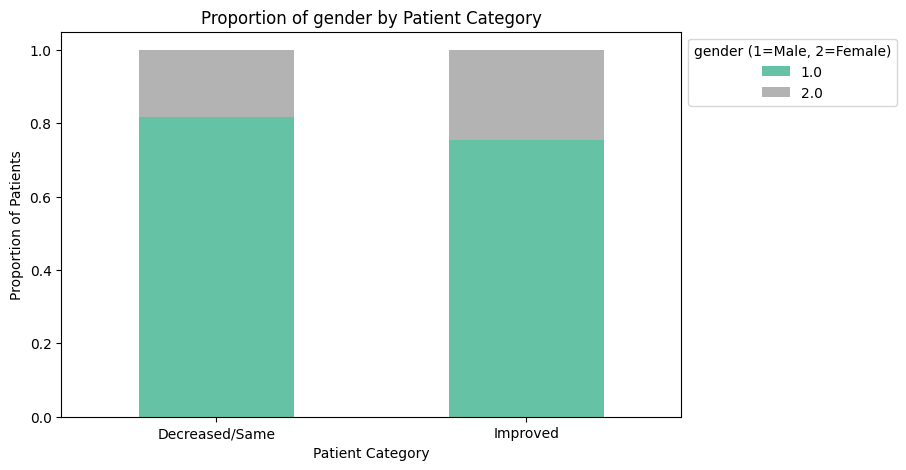

In [57]:
# Create proportion table
proportions = merged_df_removedNA_gender.groupby("Trend Category")["gender"].value_counts(normalize=True).unstack()

# Plot bar chart
proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.xlabel("Patient Category")
plt.ylabel("Proportion of Patients")
plt.title("Proportion of gender by Patient Category")
plt.legend(title="gender (1=Male, 2=Female)", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()


# statistically significantly associated with 6) clinical staging (overall_primary_tumour)

In [83]:
# Merge score_comparison with overall_primary_tumour data
merged_df_tumor = score_comparison.merge(df_extracted[["id", "overall_primary_tumour"]], on="id", how="left")

# Remove rows where overall_primary_tumour is missing
merged_df_removedNA_tumour = merged_df_tumor.dropna(subset=["overall_primary_tumour"])
merged_df_expanded_tumour = merged_df_removedNA_tumour.drop_duplicates()
merged_df_removedNA_tumour = merged_df_expanded_tumour.copy()
merged_df_removedNA_tumour

,id,Baseline,Preoperative,Change,Trend,Trend Category,overall_primary_tumour
2,55,8.0,14.0,6.0,Improved,Improved,3
13,78,17.0,20.0,3.0,Improved,Improved,4
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,3
27,127,5.0,12.0,7.0,Improved,Improved,2
32,128,22.0,23.0,1.0,Improved,Improved,3
...,...,...,...,...,...,...,...
2165,1723,18.0,18.0,0.0,Same,Decreased/Same,3
2173,1729,18.0,24.0,6.0,Improved,Improved,3
2180,1736,20.0,21.0,1.0,Improved,Improved,3
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,3


In [84]:
# Ensure the "overall_primary_tumour" column is numeric
tumor_mapping = {
    "99": None,  # "X" is unclear; assuming it should be NaN or ignored
    "0": 0, 
    "00": 0, 
    "1": 1, "1a": 1, "1b": 1, 
    "2": 2, 
    "3": 3, 
    "4": 4, "4a": 4, 
    "4b": 4,  # Kept as 4 unless you want it separate
    "5": None  # "Unknown" should be NaN
}

# Apply mapping to convert tumor stage to numeric
merged_df_removedNA_tumour["overall_primary_tumour"] = merged_df_removedNA_tumour["overall_primary_tumour"].map(tumor_mapping)

# Remove any NaN values after mapping
merged_df_removedNA_tumour = merged_df_removedNA_tumour.dropna(subset=["overall_primary_tumour"])
merged_df_removedNA_tumour

,id,Baseline,Preoperative,Change,Trend,Trend Category,overall_primary_tumour
2,55,8.0,14.0,6.0,Improved,Improved,3.0
13,78,17.0,20.0,3.0,Improved,Improved,4.0
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,3.0
27,127,5.0,12.0,7.0,Improved,Improved,2.0
32,128,22.0,23.0,1.0,Improved,Improved,3.0
...,...,...,...,...,...,...,...
2165,1723,18.0,18.0,0.0,Same,Decreased/Same,3.0
2173,1729,18.0,24.0,6.0,Improved,Improved,3.0
2180,1736,20.0,21.0,1.0,Improved,Improved,3.0
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,3.0


In [81]:
# Separate tumor stages by Trend Category
tumor_improved = merged_df_removedNA_tumour.loc[merged_df_removedNA_tumour["Trend Category"] == "Improved", "overall_primary_tumour"]
tumor_not_improved = merged_df_removedNA_tumour.loc[merged_df_removedNA_tumour["Trend Category"] == "Decreased/Same", "overall_primary_tumour"]

# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(tumor_improved, tumor_not_improved, alternative="greater")

# Print test results
print(f"Mann-Whitney U Test statistic: {u_stat}")
print(f"Mann-Whitney U Test p-value: {p_value}")

Mann-Whitney U Test statistic: 8872.0
Mann-Whitney U Test p-value: 0.1398912708134385


In [82]:
# Calculate mean tumor stage for each category
avg_tumor_improved = tumor_improved.mean()
avg_tumor_not_improved = tumor_not_improved.mean()

print(f"Average tumor stage for Improved: {avg_tumor_improved:.2f}")
print(f"Average tumor stage for Not Improved: {avg_tumor_not_improved:.2f}")

Average tumor stage for Improved: 2.89
Average tumor stage for Not Improved: 2.78


/tmp/ipykernel_1184410/2039952387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_removedNA_tumour["Trend Category_binary"] = merged_df_removedNA_tumour["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})
/tmp/ipykernel_1184410/2039952387.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trend Category", y="overall_primary_tumour", data=merged_df_removedNA_tumour, palette="Set2")


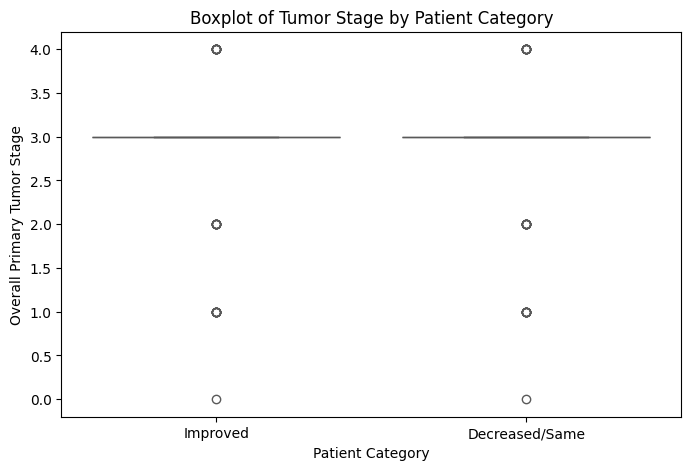

/tmp/ipykernel_1184410/2039952387.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Trend Category", y="overall_primary_tumour", data=merged_df_removedNA_tumour, palette="Set2", inner="quartile")


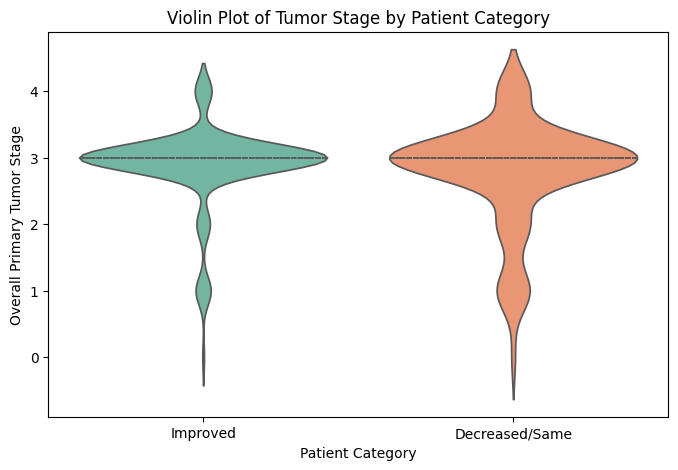

In [85]:
# Encode Trend Category as binary
merged_df_removedNA_tumour["Trend Category_binary"] = merged_df_removedNA_tumour["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

## ==== Boxplot ====
plt.figure(figsize=(8, 5))
sns.boxplot(x="Trend Category", y="overall_primary_tumour", data=merged_df_removedNA_tumour, palette="Set2")
plt.xlabel("Patient Category")
plt.ylabel("Overall Primary Tumor Stage")
plt.title("Boxplot of Tumor Stage by Patient Category")
plt.show()

## ==== Violin Plot ====
plt.figure(figsize=(8, 5))
sns.violinplot(x="Trend Category", y="overall_primary_tumour", data=merged_df_removedNA_tumour, palette="Set2", inner="quartile")
plt.xlabel("Patient Category")
plt.ylabel("Overall Primary Tumor Stage")
plt.title("Violin Plot of Tumor Stage by Patient Category")
plt.show()


# statistically significantly associated with 7) clinical staging (overall_regional_ln)

In [89]:
# Merge score_comparison with overall_regional_ln data
merged_df_ln = score_comparison.merge(df_extracted[["id", "overall_regional_ln"]], on="id", how="left")

# Remove rows where overall_regional_ln is missing
merged_df_removedNA_ln = merged_df_ln.dropna(subset=["overall_regional_ln"])
merged_df_expanded_ln = merged_df_removedNA_ln.drop_duplicates()
merged_df_removedNA_ln = merged_df_expanded_ln.copy()
merged_df_removedNA_ln

,id,Baseline,Preoperative,Change,Trend,Trend Category,overall_regional_ln
2,55,8.0,14.0,6.0,Improved,Improved,1
13,78,17.0,20.0,3.0,Improved,Improved,3
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,1
27,127,5.0,12.0,7.0,Improved,Improved,1
32,128,22.0,23.0,1.0,Improved,Improved,3
...,...,...,...,...,...,...,...
2165,1723,18.0,18.0,0.0,Same,Decreased/Same,0
2173,1729,18.0,24.0,6.0,Improved,Improved,1
2180,1736,20.0,21.0,1.0,Improved,Improved,1
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,0


In [90]:
regional_ln_mapping = {
    "99": None,  # "X" likely means unknown/missing
    "0": 0, 
    "1": 1, 
    "2": 2, 
    "3": 3, 
    "4": 4,
    "pos": 1  # Assuming "pos" means lymph node involvement (map to 1) 
}

# Apply mapping to convert ln stage to numeric
merged_df_removedNA_ln["overall_regional_ln"] = merged_df_removedNA_ln["overall_regional_ln"].map(regional_ln_mapping)

# Remove any NaN values after mapping
merged_df_removedNA_ln = merged_df_removedNA_ln.dropna(subset=["overall_regional_ln"])
merged_df_removedNA_ln

,id,Baseline,Preoperative,Change,Trend,Trend Category,overall_regional_ln
2,55,8.0,14.0,6.0,Improved,Improved,1.0
13,78,17.0,20.0,3.0,Improved,Improved,3.0
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,1.0
27,127,5.0,12.0,7.0,Improved,Improved,1.0
32,128,22.0,23.0,1.0,Improved,Improved,3.0
...,...,...,...,...,...,...,...
2165,1723,18.0,18.0,0.0,Same,Decreased/Same,0.0
2173,1729,18.0,24.0,6.0,Improved,Improved,1.0
2180,1736,20.0,21.0,1.0,Improved,Improved,1.0
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,0.0


In [93]:
# Separate ln stages by Trend Category
ln_improved = merged_df_removedNA_ln.loc[merged_df_removedNA_ln["Trend Category"] == "Improved", "overall_regional_ln"]
ln_not_improved = merged_df_removedNA_ln.loc[merged_df_removedNA_ln["Trend Category"] == "Decreased/Same", "overall_regional_ln"]

# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(ln_improved, ln_not_improved, alternative="greater")

# Print test results
print(f"Mann-Whitney U Test statistic: {u_stat}")
print(f"Mann-Whitney U Test p-value: {p_value}")

Mann-Whitney U Test statistic: 9544.0
Mann-Whitney U Test p-value: 0.014040234963621844


In [94]:
# Calculate mean ln stage for each category
avg_ln_improved = ln_improved.mean()
avg_ln_not_improved = ln_not_improved.mean()

print(f"Average ln stage for Improved: {avg_ln_improved:.2f}")
print(f"Average ln stage for Not Improved: {avg_ln_not_improved:.2f}")

Average ln stage for Improved: 0.95
Average ln stage for Not Improved: 0.69


/tmp/ipykernel_1184410/2846874025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_removedNA_ln["Trend Category_binary"] = merged_df_removedNA_ln["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})
/tmp/ipykernel_1184410/2846874025.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Trend Category", y="overall_regional_ln", data=merged_df_removedNA_ln, palette="Set2")


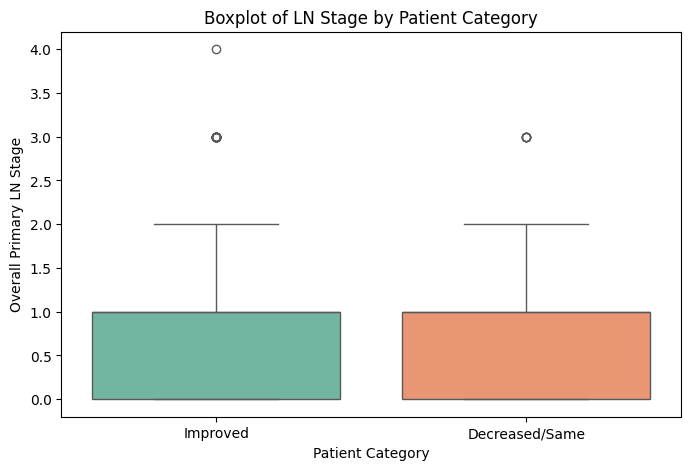

/tmp/ipykernel_1184410/2846874025.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Trend Category", y="overall_regional_ln", data=merged_df_removedNA_ln, palette="Set2", inner="quartile")


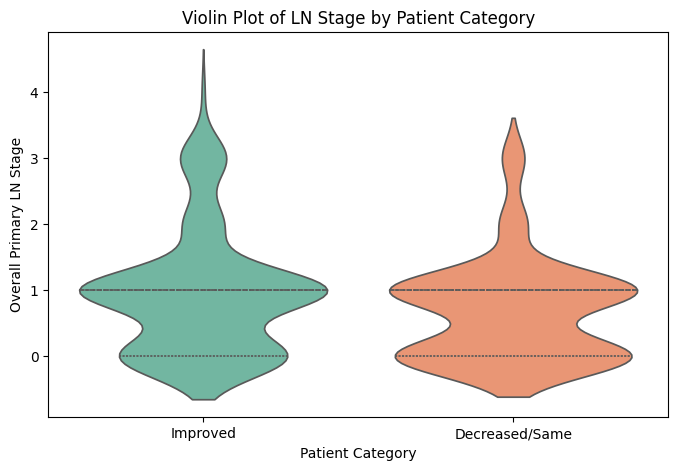

In [95]:
# Encode Trend Category as binary
merged_df_removedNA_ln["Trend Category_binary"] = merged_df_removedNA_ln["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

## ==== Boxplot ====
plt.figure(figsize=(8, 5))
sns.boxplot(x="Trend Category", y="overall_regional_ln", data=merged_df_removedNA_ln, palette="Set2")
plt.xlabel("Patient Category")
plt.ylabel("Overall Primary LN Stage")
plt.title("Boxplot of LN Stage by Patient Category")
plt.show()

## ==== Violin Plot ====
plt.figure(figsize=(8, 5))
sns.violinplot(x="Trend Category", y="overall_regional_ln", data=merged_df_removedNA_ln, palette="Set2", inner="quartile")
plt.xlabel("Patient Category")
plt.ylabel("Overall Primary LN Stage")
plt.title("Violin Plot of LN Stage by Patient Category")
plt.show()


# statistically significantly associated with 8) clinical staging (overall_distant_metastasis)

In [97]:
# Merge score_comparison with overall_distant_metastasis data
merged_df_M = score_comparison.merge(df_extracted[["id", "overall_distant_metastasis"]], on="id", how="left")

# Remove rows where overall_distant_metastasis is missing
merged_df_removedNA_M = merged_df_M.dropna(subset=["overall_distant_metastasis"])
merged_df_expanded_M = merged_df_removedNA_M.drop_duplicates()
merged_df_removedNA_M = merged_df_expanded_M.copy()
merged_df_removedNA_M

,id,Baseline,Preoperative,Change,Trend,Trend Category,overall_distant_metastasis
2,55,8.0,14.0,6.0,Improved,Improved,0.0
13,78,17.0,20.0,3.0,Improved,Improved,0.0
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,1.0
27,127,5.0,12.0,7.0,Improved,Improved,0.0
32,128,22.0,23.0,1.0,Improved,Improved,0.0
...,...,...,...,...,...,...,...
2165,1723,18.0,18.0,0.0,Same,Decreased/Same,0.0
2173,1729,18.0,24.0,6.0,Improved,Improved,0.0
2180,1736,20.0,21.0,1.0,Improved,Improved,0.0
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,0.0


In [101]:
regional_M_mapping = {
    0: 0,
    1: 1,
    2: None
}

# Apply mapping to convert ln stage to numeric
merged_df_removedNA_M["overall_distant_metastasis"] = merged_df_removedNA_M["overall_distant_metastasis"].map(regional_M_mapping)

# Remove any NaN values after mapping
merged_df_removedNA_M = merged_df_removedNA_M.dropna(subset=["overall_distant_metastasis"])
merged_df_removedNA_M

,id,Baseline,Preoperative,Change,Trend,Trend Category,overall_distant_metastasis
2,55,8.0,14.0,6.0,Improved,Improved,0.0
13,78,17.0,20.0,3.0,Improved,Improved,0.0
23,125,21.0,16.0,-5.0,Decreased,Decreased/Same,1.0
27,127,5.0,12.0,7.0,Improved,Improved,0.0
32,128,22.0,23.0,1.0,Improved,Improved,0.0
...,...,...,...,...,...,...,...
2165,1723,18.0,18.0,0.0,Same,Decreased/Same,0.0
2173,1729,18.0,24.0,6.0,Improved,Improved,0.0
2180,1736,20.0,21.0,1.0,Improved,Improved,0.0
2185,1737,21.0,7.0,-14.0,Decreased,Decreased/Same,0.0


### Chi-square test

In [102]:
# Create a contingency table
contingency_table_M = pd.crosstab(merged_df_removedNA_M["Trend Category"], merged_df_removedNA_M["overall_distant_metastasis"])
print(contingency_table_M)

# Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table_M)

print(f"Chi-Square Test p-value: {p_value}")


overall_distant_metastasis  0.0  1.0
Trend Category                      
Decreased/Same               82    7
Improved                    150   23
Chi-Square Test p-value: 0.270312207610408


### Fisher's exact test

In [103]:
odds_ratio, p_value = stats.fisher_exact(contingency_table_M)
print(f"Fisher's Exact Test p-value: {p_value}")

Fisher's Exact Test p-value: 0.22347216552749352


### Logistic test

In [104]:
# Convert categorical variable to binary (1 = Improved, 0 = Decreased/Same)
merged_df_removedNA_M["Trend Category_binary"] = merged_df_removedNA_M["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

# Logistic Regression Model
X = sm.add_constant(merged_df_removedNA_M["Trend Category_binary"])  # Predictor
y = merged_df_removedNA_M["overall_distant_metastasis"]  # Outcome (0/1)

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.352382
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     overall_distant_metastasis   No. Observations:                  262
Model:                                  Logit   Df Residuals:                      260
Method:                                   MLE   Df Model:                            1
Date:                        Wed, 12 Mar 2025   Pseudo R-squ.:                0.009688
Time:                                20:19:34   Log-Likelihood:                -92.324
converged:                               True   LL-Null:                       -93.227
Covariance Type:                    nonrobust   LLR p-value:                    0.1789
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 

/tmp/ipykernel_1184410/4056887950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_removedNA_M["Trend Category_binary"] = merged_df_removedNA_M["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})


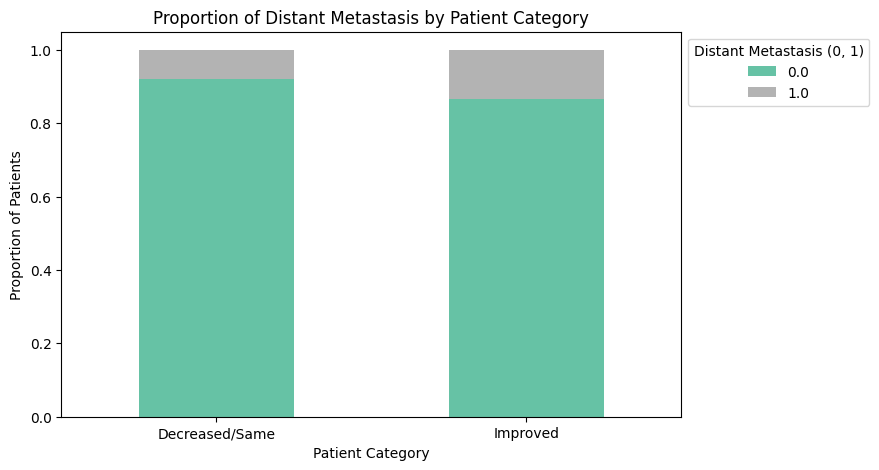

In [105]:
# Create proportion table
proportions = merged_df_removedNA_M.groupby("Trend Category")["overall_distant_metastasis"].value_counts(normalize=True).unstack()

# Plot bar chart
proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
plt.xlabel("Patient Category")
plt.ylabel("Proportion of Patients")
plt.title("Proportion of Distant Metastasis by Patient Category")
plt.legend(title="Distant Metastasis (0, 1)", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show()


# statistically significantly associated with 9) Neoadjuvant treatment (six neotx)


### Analyzing: neotx___notx ###

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
0       55       8.0          14.0     6.0   Improved        Improved   
11      78      17.0          20.0     3.0   Improved        Improved   
21     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
30     127       5.0          12.0     7.0   Improved        Improved   
40     128      22.0          23.0     1.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
2176  1729      18.0          24.0     6.0   Improved        Improved   
2183  1736      20.0          21.0     1.0   Improved        Improved   
2188  1737      21.0           7.0   -14.0  Decreased  Decreased/Same   
2190  1739      13.0          20.0     7.0   Improved        Improved   
2194  1744      19.0          20.0     1.0   Improved        Improved   

      neotx___notx  
0              0.0  
11             0.0  
21             0.0  
30   

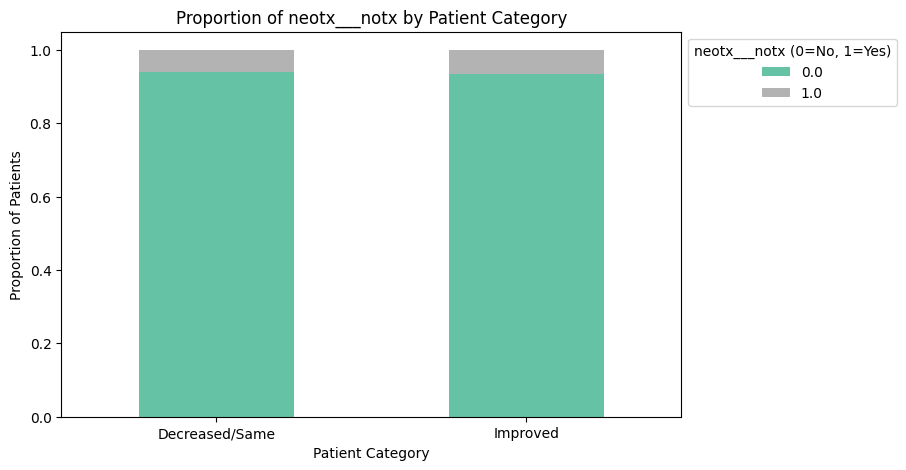


### Analyzing: neotx___chemo ###

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
0       55       8.0          14.0     6.0   Improved        Improved   
11      78      17.0          20.0     3.0   Improved        Improved   
21     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
30     127       5.0          12.0     7.0   Improved        Improved   
40     128      22.0          23.0     1.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
2176  1729      18.0          24.0     6.0   Improved        Improved   
2183  1736      20.0          21.0     1.0   Improved        Improved   
2188  1737      21.0           7.0   -14.0  Decreased  Decreased/Same   
2190  1739      13.0          20.0     7.0   Improved        Improved   
2194  1744      19.0          20.0     1.0   Improved        Improved   

      neotx___chemo  
0               1.0  
11              1.0  
21              1.0  


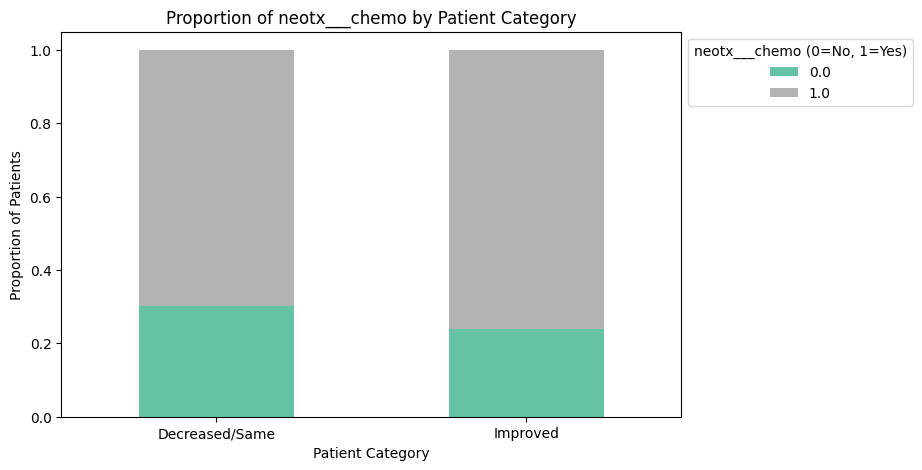


### Analyzing: neotx___rads ###

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
0       55       8.0          14.0     6.0   Improved        Improved   
11      78      17.0          20.0     3.0   Improved        Improved   
21     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
30     127       5.0          12.0     7.0   Improved        Improved   
40     128      22.0          23.0     1.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
2176  1729      18.0          24.0     6.0   Improved        Improved   
2183  1736      20.0          21.0     1.0   Improved        Improved   
2188  1737      21.0           7.0   -14.0  Decreased  Decreased/Same   
2190  1739      13.0          20.0     7.0   Improved        Improved   
2194  1744      19.0          20.0     1.0   Improved        Improved   

      neotx___rads  
0              1.0  
11             0.0  
21             0.0  
30   

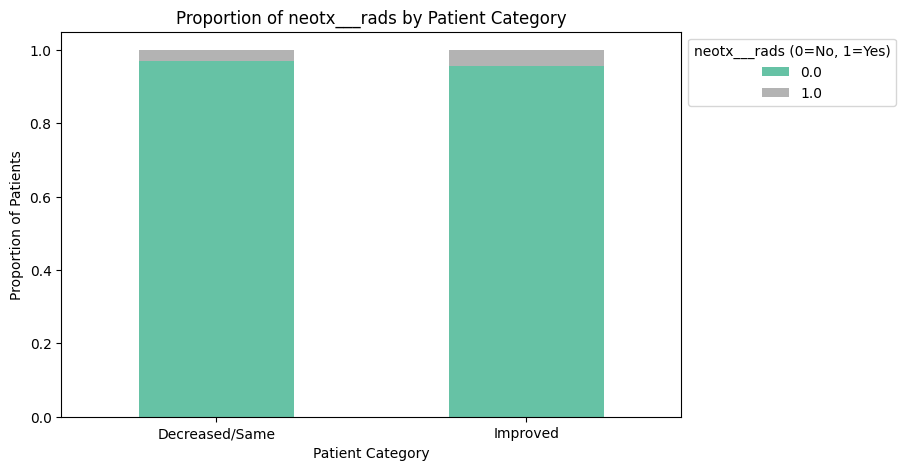


### Analyzing: neotx___chemorads ###

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
0       55       8.0          14.0     6.0   Improved        Improved   
11      78      17.0          20.0     3.0   Improved        Improved   
21     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
30     127       5.0          12.0     7.0   Improved        Improved   
40     128      22.0          23.0     1.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
2176  1729      18.0          24.0     6.0   Improved        Improved   
2183  1736      20.0          21.0     1.0   Improved        Improved   
2188  1737      21.0           7.0   -14.0  Decreased  Decreased/Same   
2190  1739      13.0          20.0     7.0   Improved        Improved   
2194  1744      19.0          20.0     1.0   Improved        Improved   

      neotx___chemorads  
0                   0.0  
11                  0.0  
21    

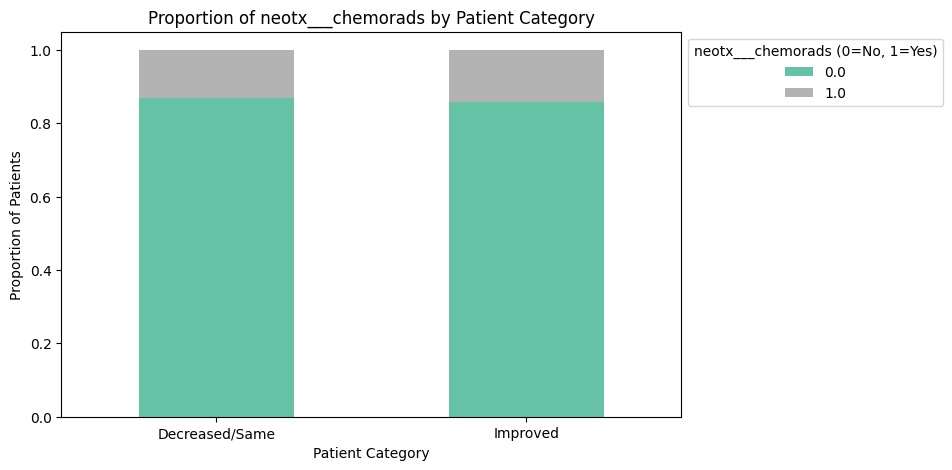


### Analyzing: neotx___immuno ###

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
0       55       8.0          14.0     6.0   Improved        Improved   
11      78      17.0          20.0     3.0   Improved        Improved   
21     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
30     127       5.0          12.0     7.0   Improved        Improved   
40     128      22.0          23.0     1.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
2176  1729      18.0          24.0     6.0   Improved        Improved   
2183  1736      20.0          21.0     1.0   Improved        Improved   
2188  1737      21.0           7.0   -14.0  Decreased  Decreased/Same   
2190  1739      13.0          20.0     7.0   Improved        Improved   
2194  1744      19.0          20.0     1.0   Improved        Improved   

      neotx___immuno  
0                0.0  
11               0.0  
21               0

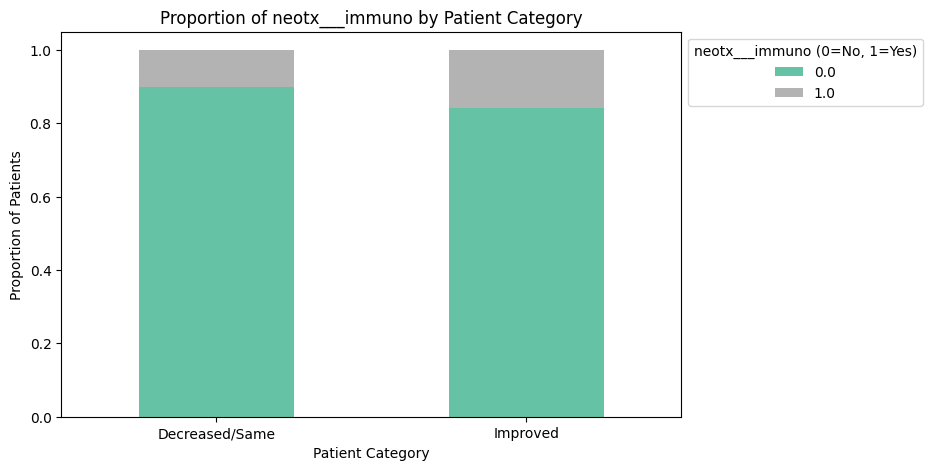


### Analyzing: neotx___other ###

        id  Baseline  Preoperative  Change      Trend  Trend Category  \
0       55       8.0          14.0     6.0   Improved        Improved   
11      78      17.0          20.0     3.0   Improved        Improved   
21     125      21.0          16.0    -5.0  Decreased  Decreased/Same   
30     127       5.0          12.0     7.0   Improved        Improved   
40     128      22.0          23.0     1.0   Improved        Improved   
...    ...       ...           ...     ...        ...             ...   
2176  1729      18.0          24.0     6.0   Improved        Improved   
2183  1736      20.0          21.0     1.0   Improved        Improved   
2188  1737      21.0           7.0   -14.0  Decreased  Decreased/Same   
2190  1739      13.0          20.0     7.0   Improved        Improved   
2194  1744      19.0          20.0     1.0   Improved        Improved   

      neotx___other  
0               0.0  
11              0.0  
21              0.0  


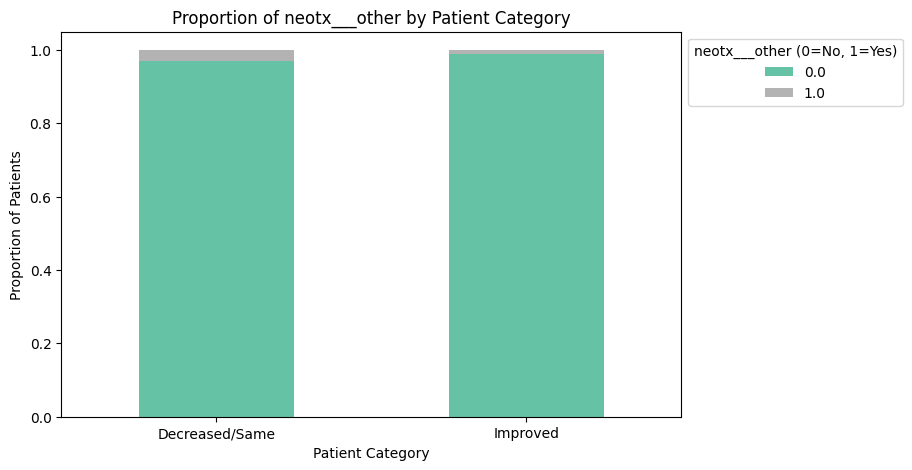

In [118]:
# List of binary treatment columns
treatment_columns = ["neotx___notx", "neotx___chemo", "neotx___rads", 
                    "neotx___chemorads", "neotx___immuno", "neotx___other"]

for col in treatment_columns:
    print(f"\n### Analyzing: {col} ###\n")
    
    # Merge data
    merged_df = score_comparison.merge(df_extracted[["id", col]], on="id", how="left")
    
    # Remove rows where treatment data is missing
    merged_df = merged_df.dropna(subset=[col])
    merged_df = merged_df.drop_duplicates()
    print(merged_df)
    # Create a contingency table
    contingency_table = pd.crosstab(merged_df["Trend Category"], merged_df[col])
    print(contingency_table)
    
    # Chi-square test
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-Square Test p-value: {p_value}")

    # Fisher's Exact Test (only if 2x2 table)
    if contingency_table.shape == (2, 2):
        odds_ratio, p_value_fisher = stats.fisher_exact(contingency_table)
        print(f"Fisher's Exact Test p-value: {p_value_fisher}")

    # Convert Trend Category to binary (1 = Improved, 0 = Decreased/Same)
    merged_df["Trend Category_binary"] = merged_df["Trend Category"].map({"Improved": 1, "Decreased/Same": 0})

    # Logistic Regression Model
    X = sm.add_constant(merged_df["Trend Category_binary"])
    y = merged_df[col]  # Treatment variable (0/1)
    
    try:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit(disp=0)
        print(result.summary())
    except Exception as e:
        print(f"Logistic regression failed: {e}")

    # Create proportion table
    proportions = merged_df.groupby("Trend Category")[col].value_counts(normalize=True).unstack()

    # Plot bar chart
    proportions.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 5))
    plt.xlabel("Patient Category")
    plt.ylabel("Proportion of Patients")
    plt.title(f"Proportion of {col} by Patient Category")
    plt.legend(title=f"{col} (0=No, 1=Yes)", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=0)
    plt.show()


# statistically significantly associated with 10) surgery type (procedure123456)

In [121]:
# Merge score_comparison with procedure123456 data
merged_df_procedure = score_comparison.merge(df_extracted[["id", "procedure123456"]], on="id", how="left")

# Remove rows where procedure123456 is missing
merged_df_removedNA_procedure = merged_df_procedure.dropna(subset=["procedure123456"])
merged_df_expanded_procedure = merged_df_removedNA_procedure.drop_duplicates()
merged_df_removedNA_procedure = merged_df_expanded_procedure.copy()
merged_df_removedNA_procedure

,id,Baseline,Preoperative,Change,Trend,Trend Category,procedure123456
6,55,8.0,14.0,6.0,Improved,Improved,1.0
16,78,17.0,20.0,3.0,Improved,Improved,4.0
24,125,21.0,16.0,-5.0,Decreased,Decreased/Same,1.0
25,127,5.0,12.0,7.0,Improved,Improved,2.0
36,128,22.0,23.0,1.0,Improved,Improved,1.0
...,...,...,...,...,...,...,...
2134,1708,15.0,17.0,2.0,Improved,Improved,1.0
2152,1720,18.0,19.0,1.0,Improved,Improved,1.0
2160,1721,12.0,19.0,7.0,Improved,Improved,1.0
2162,1723,18.0,18.0,0.0,Same,Decreased/Same,1.0


### Chi-square test

In [124]:
# Create a contingency table
contingency_table_procedure = pd.crosstab(merged_df_removedNA_procedure["Trend Category"], merged_df_removedNA_procedure["procedure123456"])
print(contingency_table_procedure)

# Perform Chi-Square test
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table_procedure)

print(f"Chi-Square statistic: {chi2_stat}")
print(f"P-value: {p_val}")


procedure123456  1.0  2.0  3.0  4.0  5.0  6.0  8.0
Trend Category                                    
Decreased/Same    46   14    1   10    6    0    1
Improved         103   18    3   13    3    2    6
Chi-Square statistic: 9.497868592794914
P-value: 0.14745323075618955


### Logistic test